In [1]:
import numpy as np
import pandas as pd
import sklearn.datasets
import math
import dowhy
from dowhy import CausalModel
from numpy.random import choice


# Disable some warnings
import logging
logging.getLogger("dowhy").setLevel(logging.ERROR)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def stochastically_convert_to_binary(p):
    return choice([0, 1], 1, p=[1-p, p])

def generate_dataset(num_samples,
                      beta, 
                      num_confounders, 
                      variance_outcome):
    cov_mat = sklearn.datasets.make_spd_matrix(num_confounders)*10
    means_vec = np.random.uniform(-1, 1, num_confounders)
    W = np.random.multivariate_normal(means_vec, cov_mat, size=num_samples)
    
    # Coefficients of W
    coeff_W_t = np.random.uniform(-1, 1, num_confounders)
    coeff_W_y = np.random.uniform(-abs(beta),abs(beta), num_confounders)
    
    # Generating the action 
    eps_t = np.random.normal(0, 1, num_samples)
    t = W @ coeff_W_t + eps_t
    if True:
        prop = np.vectorize(sigmoid)(t)
        prop = np.where(prop>0.95, 0.95, prop)
        prop = np.where(prop<0.05, 0.05, prop)
        t = np.vectorize(stochastically_convert_to_binary)(prop)

    
    # Generating outcome
    eps_y = np.random.normal(0, math.sqrt(variance_outcome), num_samples)
    y = beta*t + W @ coeff_W_y + W[:,0]*W[:,0] +  eps_y
    df = pd.DataFrame({'action':t, "outcome":y})
    for i in range(num_confounders): 
        df["w"+str(i)] = W[:, i]
    df = df.astype({'action':'bool'}, copy=False)
    return df

In [3]:
def estimate_effect(model, df, colname="action"):
    newdf=df.copy(deep=True)
    newdf.loc[:, colname] = 1
    y1 = model.predict(newdf)
    newdf.loc[:,colname]=0
    y0=model.predict(newdf)
    return np.mean(y1-y0)

def mae(model, dat, feature_names, num_samples, output_name="outcome"):
    X = dat[feature_names]
    X = pd.get_dummies(X, drop_first=True)                
    X, T = check_X_y(X, dat["action"], multi_output=False, y_numeric=True)
    T = OneHotEncoder().fit_transform(T.reshape(-1,1))
    X = np.reshape(X, (num_samples, X.shape[1]))
    feat_arr = np.concatenate((X,T.toarray()), axis=1)
    mae_err = np.mean(np.abs((model.predict(feat_arr) - dat[output_name])/dat[output_name]))
    return mae_err

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import check_X_y

num_simulations=1000
num_data_samples=1000
beta=10
num_confounders=10 
var_eps=10
methods = ["backdoor.econml.metalearners.SLearner"]*4
ml_models = [RandomForestRegressor(),GradientBoostingRegressor(), LinearRegression(), Lasso()]
ml_models_str = [ "RandomForest", "GradientBoosting", "LinearRegression", "Lasso"]

method_params = [{'init_params':{'overall_model': ml_model},'fit_params':{}} for ml_model in ml_models]
estimates = [[0.0] * num_simulations for i in range(len(methods))]
test_error = [[0.0] * num_simulations for i in range(len(methods))]
train_error = [[0.0] * num_simulations for i in range(len(methods))]
i = 0
while i < num_simulations:    
    data = generate_dataset(num_samples = num_data_samples,
                                 beta=beta,
                                 num_confounders=num_confounders,
                                 variance_outcome=var_eps
                                )
    test_data = generate_dataset(num_samples = num_data_samples,
                                 beta=beta,
                                 num_confounders=num_confounders,
                                 variance_outcome=var_eps
                                )
    cmodel = CausalModel(data,
                        treatment="action",
                        outcome="outcome",
                        common_causes=["w"+str(i) for i in range(num_confounders)],
                        effect_modifiers=["w"+str(i) for i in range(num_confounders)])
            
    identified_estimand = cmodel.identify_effect(proceed_when_unidentifiable=True)
    
    for j in range(len(methods)):
        estimate = cmodel.estimate_effect(identified_estimand, 
                                          method_name = methods[j],
                                          method_params = method_params[j])

        mlmodel = estimate.estimator.estimator.overall_model
        print("#", str(mlmodel))
        train_err = mae(mlmodel, data, estimate.estimator._effect_modifier_names, num_data_samples)
        print("Training Mean Absolute Percentage Error (MAPE):", str(train_err))
        #print(estimate_effect(mlmodel, test_data))
        test_err = mae(mlmodel, test_data, estimate.estimator._effect_modifier_names, num_data_samples)
        print("Test Mean Absolute Percentage Error (MAPE):", str(test_err))
        train_error[j][i] = train_err
        test_error[j][i] = test_err    
        estimates[j][i] = estimate.value
    
    print("\nCausal Estimates: ")
    print([methods[k] + ":" + str(estimates[k][i]) for k in range(len(methods))])
    print("\n\n")
    i += 1

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.43293203715833495
Test Mean Absolute Percentage Error (MAPE): 6.372500217903339
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5817161462463293
Test Mean Absolute Percentage Error (MAPE): 5.425960084971711
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.1219203183051099
Test Mean Absolute Percentage Error (MAPE): 6.503454151150363
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.1206113068561279
Test Mean Absolute Percentage Error (MAPE): 6.630009698659718

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:9.153106705767506', 'backdoor.econml.metalearners.SLearner:10.741656346431387', 'backdoor.econml.metalearners.SLearner:9.49498369104867', 'backdoor.econml.metalearners.SLearner:2.8851175398172995']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.2312388832188006
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6965081177636432
Test Mean Absolute Percentage Error (MAPE): 3.2851635519576763
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.5638780766893166
Test Mean Absolute Percentage Error (MAPE): 3.1954603677685154
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.8671216454102857
Test Mean Absolute Percentage Error (MAPE): 4.644473599408544
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.8840831276074244
Test Mean Absolute Percentage Error (MAPE): 4.12116791234744

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:16.449563732642027', 'backdoor.econml.metalearners.SLearner:19.091107244437644', 'backdoor.econml.metalearners.SLearner:7.994855536596515', 'backdoor.econml.metalearners.SLearner:1.3172997585645236']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 12.787790740839064
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.47944157055034614
Test Mean Absolute Percentage Error (MAPE): 4.006366675818676
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6858870204634819
Test Mean Absolute Percentage Error (MAPE): 4.160371202304028
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.1222212310171966
Test Mean Absolute Percentage Error (MAPE): 5.807698680401734
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.9452251239237357
Test Mean Absolute Percentage Error (MAPE): 5.0943568617521215

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.8992987755482966', 'backdoor.econml.metalearners.SLearner:4.9097390186539345', 'backdoor.econml.metalearners.SLearner:10.011728218097826', 'backdoor.econml.metalearners.SLearner:1.9942438151649704']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.809056091156043
Test Mean Absolute Percentage Error (MA

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3201322638313894
Test Mean Absolute Percentage Error (MAPE): 4.285325529827926
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.38732587894376125
Test Mean Absolute Percentage Error (MAPE): 5.344408961360827
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.26598945222743453
Test Mean Absolute Percentage Error (MAPE): 7.824576310551031
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.3253431718204856
Test Mean Absolute Percentage Error (MAPE): 7.447782001615795

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.7935295663532023', 'backdoor.econml.metalearners.SLearner:5.795910638626282', 'backdoor.econml.metalearners.SLearner:10.087610907819528', 'backdoor.econml.metalearners.SLearner:2.8729574131251927']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4611269308717527
Test Mean Absolute Percentage Error (MA

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.39072502527673864
Test Mean Absolute Percentage Error (MAPE): 1.9572110945661008
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6664940588300317
Test Mean Absolute Percentage Error (MAPE): 2.101581384850588
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.930661420637454
Test Mean Absolute Percentage Error (MAPE): 2.8723809639473976
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.01086576126084
Test Mean Absolute Percentage Error (MAPE): 2.7296022656393975

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.17762734321828363', 'backdoor.econml.metalearners.SLearner:2.7506878011159226', 'backdoor.econml.metalearners.SLearner:8.958549254911999', 'backdoor.econml.metalearners.SLearner:1.1134232456009858']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.37074023754032587
Test Mean Absolute Percentage Error (M

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.20542998721411032
Test Mean Absolute Percentage Error (MAPE): 19.870994646331866
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.30576718025025085
Test Mean Absolute Percentage Error (MAPE): 29.312669438654392
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.32509749930518456
Test Mean Absolute Percentage Error (MAPE): 27.744413689139343
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.3555558655764894
Test Mean Absolute Percentage Error (MAPE): 27.507313200782196

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:6.898318040831112', 'backdoor.econml.metalearners.SLearner:12.90217261267394', 'backdoor.econml.metalearners.SLearner:9.820344896720137', 'backdoor.econml.metalearners.SLearner:2.6308622342096677']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7757269377875919
Test Mean Absolute Percentage Error 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4333989627967712
Test Mean Absolute Percentage Error (MAPE): 3.7805865410001216
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5113524256529913
Test Mean Absolute Percentage Error (MAPE): 9.220548958852714
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.1012784438595853
Test Mean Absolute Percentage Error (MAPE): 16.897387567901053
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.1553818052047042
Test Mean Absolute Percentage Error (MAPE): 15.228059882030273

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:3.4167510587457537', 'backdoor.econml.metalearners.SLearner:4.287041056865099', 'backdoor.econml.metalearners.SLearner:20.3476264745732', 'backdoor.econml.metalearners.SLearner:13.084682863294544']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.45094765252380214
Test Mean Absolute Percentage Error (MA

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5252895597262586
Test Mean Absolute Percentage Error (MAPE): 3.9242781707425793
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.69653981947573
Test Mean Absolute Percentage Error (MAPE): 4.159932975747029
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.5097942298345706
Test Mean Absolute Percentage Error (MAPE): 5.579084707029239
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.5059915248079319
Test Mean Absolute Percentage Error (MAPE): 5.644277783842454

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.9104586715325038', 'backdoor.econml.metalearners.SLearner:2.001516028663235', 'backdoor.econml.metalearners.SLearner:8.799988562189183', 'backdoor.econml.metalearners.SLearner:0.9197022597648911']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6588510323141893
Test Mean Absolute Percentage Error (MAPE):

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8475928306781582
Test Mean Absolute Percentage Error (MAPE): 2.825176108545299
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.351837212781824
Test Mean Absolute Percentage Error (MAPE): 2.511940523446643
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.0237519433789473
Test Mean Absolute Percentage Error (MAPE): 3.7707726154580503
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.2136178040302026
Test Mean Absolute Percentage Error (MAPE): 3.738927144209365

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.9947361639290435', 'backdoor.econml.metalearners.SLearner:4.250215884607906', 'backdoor.econml.metalearners.SLearner:10.329309387368873', 'backdoor.econml.metalearners.SLearner:3.53951690397304']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5096864191644317
Test Mean Absolute Percentage Error (MAPE):

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 11.231439206594159
Test Mean Absolute Percentage Error (MAPE): 2.7305113108309707
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 6.552831017771064
Test Mean Absolute Percentage Error (MAPE): 2.8703306465325906
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 4.266990296458068
Test Mean Absolute Percentage Error (MAPE): 3.3996227068938327
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 4.4136702722891545
Test Mean Absolute Percentage Error (MAPE): 2.9213685888728307

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.432704293059503', 'backdoor.econml.metalearners.SLearner:4.8400304849065225', 'backdoor.econml.metalearners.SLearner:11.893828886518696', 'backdoor.econml.metalearners.SLearner:5.047803079154192']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.066207385163624
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4299640105231361
Test Mean Absolute Percentage Error (MAPE): 3.4698874881516257
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6717964967318899
Test Mean Absolute Percentage Error (MAPE): 3.787089481762133
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.6486010984297989
Test Mean Absolute Percentage Error (MAPE): 4.185641182376483
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.7284907688622994
Test Mean Absolute Percentage Error (MAPE): 4.106277583689458

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.08872299145822628', 'backdoor.econml.metalearners.SLearner:2.165215025471859', 'backdoor.econml.metalearners.SLearner:8.533625962751707', 'backdoor.econml.metalearners.SLearner:0.8516445579342397']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.48901990346201757
Test Mean Absolute Percentage Error (MA

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.19368347017167223
Test Mean Absolute Percentage Error (MAPE): 2.225484699578179
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.23204545803843307
Test Mean Absolute Percentage Error (MAPE): 2.2493801961907085
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.520079734121604
Test Mean Absolute Percentage Error (MAPE): 3.1712055428119683
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.530340420010778
Test Mean Absolute Percentage Error (MAPE): 2.823533341013079

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.5020742659137599', 'backdoor.econml.metalearners.SLearner:3.1641646404843806', 'backdoor.econml.metalearners.SLearner:8.063537948553549', 'backdoor.econml.metalearners.SLearner:0.3487495369076738']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6058135831464609
Test Mean Absolute Percentage Error (MA

Test Mean Absolute Percentage Error (MAPE): 1.9566382394407014

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.4681297004087522', 'backdoor.econml.metalearners.SLearner:3.0210173580331885', 'backdoor.econml.metalearners.SLearner:10.466860552149289', 'backdoor.econml.metalearners.SLearner:3.039630084524634']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5258516333640826
Test Mean Absolute Percentage Error (MAPE): 3.6525548112832875
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7324400921729189
Test Mean Absolute Percentage Error (MAPE): 4.030088173457597
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.5121172597400226
Test Mean Absolute Percentage Error (MAPE): 5.310772170790059
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.6038389339006995
Test Mean Absolute Percentage Error (MAPE): 5.084419367080816

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.20394128

# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7430502507277351
Test Mean Absolute Percentage Error (MAPE): 2.500755287589579
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.5976188086387737
Test Mean Absolute Percentage Error (MAPE): 3.906773143303869
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.6940427353743795
Test Mean Absolute Percentage Error (MAPE): 3.5418490671644003

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.4579063536228544', 'backdoor.econml.metalearners.SLearner:0.001965175534281741', 'backdoor.econml.metalearners.SLearner:10.03472057899546', 'backdoor.econml.metalearners.SLearner:1.768107354572102']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.36783788626282987
Test Mean Absolute Percentage Error (MAPE): 1.5386598267706635
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.42869313128242975
Test Mean Absolute Percentage Er

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7310246210156592
Test Mean Absolute Percentage Error (MAPE): 3.2082777932743958
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.0513005159263562
Test Mean Absolute Percentage Error (MAPE): 3.996318807562362
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.3010482797449965
Test Mean Absolute Percentage Error (MAPE): 4.870949303367181
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.2000565893834167
Test Mean Absolute Percentage Error (MAPE): 4.663779851572909

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.590831664340461', 'backdoor.econml.metalearners.SLearner:6.039022801518293', 'backdoor.econml.metalearners.SLearner:11.201456336706524', 'backdoor.econml.metalearners.SLearner:3.907791422315851']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4423521418277399
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8409766892647367
Test Mean Absolute Percentage Error (MAPE): 1.7307752872683597
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5939309576005714
Test Mean Absolute Percentage Error (MAPE): 1.9615854512742081
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.762944677632077
Test Mean Absolute Percentage Error (MAPE): 3.703703421600183
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.904541775856933
Test Mean Absolute Percentage Error (MAPE): 3.584971329118971

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.6735587247414234', 'backdoor.econml.metalearners.SLearner:0.5099677958479422', 'backdoor.econml.metalearners.SLearner:17.29983420648647', 'backdoor.econml.metalearners.SLearner:9.770512371673014']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5109374495529653
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.028972996266852
Test Mean Absolute Percentage Error (MAPE): 2.081011247761904
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.086703352019312
Test Mean Absolute Percentage Error (MAPE): 2.1062277911356357
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.8514146590489161
Test Mean Absolute Percentage Error (MAPE): 2.1869677970127572
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.991152863611154
Test Mean Absolute Percentage Error (MAPE): 2.137645307888089

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:-0.017982984234957443', 'backdoor.econml.metalearners.SLearner:0.0021226927763823796', 'backdoor.econml.metalearners.SLearner:10.660618811629792', 'backdoor.econml.metalearners.SLearner:1.4094291071598']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.4730991412890635
Test Mean Absolute Percentage Error (M

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.445407597011032
Test Mean Absolute Percentage Error (MAPE): 2.3425172902454614
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7522331948344909
Test Mean Absolute Percentage Error (MAPE): 2.4985366925229764
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.3304889405904068
Test Mean Absolute Percentage Error (MAPE): 3.4895279492656455
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.3912600287773964
Test Mean Absolute Percentage Error (MAPE): 3.1824894530336194

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.263416446942852', 'backdoor.econml.metalearners.SLearner:1.3622121872861703', 'backdoor.econml.metalearners.SLearner:8.627804564148757', 'backdoor.econml.metalearners.SLearner:0.0']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3583177530629265
Test Mean Absolute Percentage Error (MAPE): 8.69456303

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.42117532902238963
Test Mean Absolute Percentage Error (MAPE): 5.523149769705941
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.621699824402234
Test Mean Absolute Percentage Error (MAPE): 6.0151538396629824
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.4085271185249652
Test Mean Absolute Percentage Error (MAPE): 9.078693533390142
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.43048189262937253
Test Mean Absolute Percentage Error (MAPE): 9.056602622242751

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.1677243085416307', 'backdoor.econml.metalearners.SLearner:7.516672655315986', 'backdoor.econml.metalearners.SLearner:9.907268241628922', 'backdoor.econml.metalearners.SLearner:2.7427004209465315']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5341114636625054
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7734190210672036
Test Mean Absolute Percentage Error (MAPE): 2.0526876380272023
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7339469612167686
Test Mean Absolute Percentage Error (MAPE): 2.1590541740144933
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.7312443341125204
Test Mean Absolute Percentage Error (MAPE): 2.450991725476027
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.8894373244230475
Test Mean Absolute Percentage Error (MAPE): 2.386877432317594

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.3071446761078733', 'backdoor.econml.metalearners.SLearner:5.693849347216149', 'backdoor.econml.metalearners.SLearner:9.960770978149558', 'backdoor.econml.metalearners.SLearner:3.854976145084435']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6254405269257111
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.532130774848481
Test Mean Absolute Percentage Error (MAPE): 5.2179135448980904
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5873963266156425
Test Mean Absolute Percentage Error (MAPE): 7.004700115853074
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.9269217815810431
Test Mean Absolute Percentage Error (MAPE): 11.903250435964399
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.9336571456714966
Test Mean Absolute Percentage Error (MAPE): 11.611092343435281

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.3736355667937378', 'backdoor.econml.metalearners.SLearner:-0.002801683088143449', 'backdoor.econml.metalearners.SLearner:10.514717861639783', 'backdoor.econml.metalearners.SLearner:1.976448383937282']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.6169929256314934
Test Mean Absolute Percentage Error 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5280633549955107
Test Mean Absolute Percentage Error (MAPE): 2.3467458905665577
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.7777250084299745
Test Mean Absolute Percentage Error (MAPE): 1.7045018388970963
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 3.5622137541019723
Test Mean Absolute Percentage Error (MAPE): 2.6242007547973483
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 3.831318809061159
Test Mean Absolute Percentage Error (MAPE): 2.480539183514693

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.36429318171592', 'backdoor.econml.metalearners.SLearner:1.1922120068674957', 'backdoor.econml.metalearners.SLearner:12.888180494042217', 'backdoor.econml.metalearners.SLearner:4.982324484676372']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3583568629673321
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6384727904489209
Test Mean Absolute Percentage Error (MAPE): 4.320092345124437
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7599959319641901
Test Mean Absolute Percentage Error (MAPE): 4.916152905318124
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.638090538746092
Test Mean Absolute Percentage Error (MAPE): 6.164312273927888
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.8002569445357308
Test Mean Absolute Percentage Error (MAPE): 5.557301032944939

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.4371805470238983', 'backdoor.econml.metalearners.SLearner:7.440899766897595', 'backdoor.econml.metalearners.SLearner:6.546841370215921', 'backdoor.econml.metalearners.SLearner:0.4272482568345057']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4360070306490486
Test Mean Absolute Percentage Error (MAPE):

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.2672803460798863
Test Mean Absolute Percentage Error (MAPE): 7.0301871791303325
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.014186864740855
Test Mean Absolute Percentage Error (MAPE): 6.868315599951458
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.9090420779389214
Test Mean Absolute Percentage Error (MAPE): 28.493928315511432
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.447025790583631
Test Mean Absolute Percentage Error (MAPE): 26.873837104848178

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:-1.467904317888284', 'backdoor.econml.metalearners.SLearner:-3.5673971792166523', 'backdoor.econml.metalearners.SLearner:10.707067121998545', 'backdoor.econml.metalearners.SLearner:0.8977654686126427']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2953378769241597
Test Mean Absolute Percentage Error (M

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2577144279732696
Test Mean Absolute Percentage Error (MAPE): 1.9237475892044495
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.30221484360479006
Test Mean Absolute Percentage Error (MAPE): 1.8400034080138479
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.3396171047033412
Test Mean Absolute Percentage Error (MAPE): 1.86633699448482
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.33043954545613796
Test Mean Absolute Percentage Error (MAPE): 1.8682662609163478

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.22605842856514038', 'backdoor.econml.metalearners.SLearner:2.148024117746706', 'backdoor.econml.metalearners.SLearner:8.913586122681123', 'backdoor.econml.metalearners.SLearner:1.4846760176494558']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.22438636051541982
Test Mean Absolute Percentage Error 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4611164038227103
Test Mean Absolute Percentage Error (MAPE): 11.989872934923474
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6284387447775475
Test Mean Absolute Percentage Error (MAPE): 10.848878000910998
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.3661706205766766
Test Mean Absolute Percentage Error (MAPE): 10.648329135688064
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.419836927087437
Test Mean Absolute Percentage Error (MAPE): 9.348707389037894

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.3057230293522304', 'backdoor.econml.metalearners.SLearner:5.032950284976362', 'backdoor.econml.metalearners.SLearner:19.07234863782637', 'backdoor.econml.metalearners.SLearner:12.334767332571007']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5355042665694054
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.420661539178301
Test Mean Absolute Percentage Error (MAPE): 3.0259957183454342
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4400701151370655
Test Mean Absolute Percentage Error (MAPE): 2.9616779341510524
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.167746699596939
Test Mean Absolute Percentage Error (MAPE): 4.06734300694547
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.172106909529397
Test Mean Absolute Percentage Error (MAPE): 4.139599602892315

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.783331485129484', 'backdoor.econml.metalearners.SLearner:3.505568519291809', 'backdoor.econml.metalearners.SLearner:-3.781673737113881', 'backdoor.econml.metalearners.SLearner:0.0']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.23611153610814636
Test Mean Absolute Percentage Error (MAPE): 12.01767013243

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5520053926727918
Test Mean Absolute Percentage Error (MAPE): 10.587142113141372
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7695520220809429
Test Mean Absolute Percentage Error (MAPE): 10.835897876966378
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.2441568836779084
Test Mean Absolute Percentage Error (MAPE): 21.210408167530456
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.0643059216524253
Test Mean Absolute Percentage Error (MAPE): 18.1869169120097

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:5.407813132266037', 'backdoor.econml.metalearners.SLearner:14.433178499499752', 'backdoor.econml.metalearners.SLearner:11.15744508937353', 'backdoor.econml.metalearners.SLearner:4.432616073172938']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3800529217240055
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3611749782385393
Test Mean Absolute Percentage Error (MAPE): 2.082384315274378
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.48912252935649725
Test Mean Absolute Percentage Error (MAPE): 2.0196764263388696
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.68253849725317
Test Mean Absolute Percentage Error (MAPE): 2.5064038625159357
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.6437229463925154
Test Mean Absolute Percentage Error (MAPE): 2.4200346260189023

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.5542011798745772', 'backdoor.econml.metalearners.SLearner:1.32973480375612', 'backdoor.econml.metalearners.SLearner:11.654738220246712', 'backdoor.econml.metalearners.SLearner:2.870775447011738']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5894668066108275
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4998897763565455
Test Mean Absolute Percentage Error (MAPE): 3.4336589294653486
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.49244186326300926
Test Mean Absolute Percentage Error (MAPE): 3.893797885592405
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.6189434198049757
Test Mean Absolute Percentage Error (MAPE): 3.885018182312827
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.679929815363952
Test Mean Absolute Percentage Error (MAPE): 3.849828139063783

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.208059805605674', 'backdoor.econml.metalearners.SLearner:5.43146898541884', 'backdoor.econml.metalearners.SLearner:9.706173899072306', 'backdoor.econml.metalearners.SLearner:2.4226242677372816']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5046314515647491
Test Mean Absolute Percentage Error (MAPE):

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.48883536869862815
Test Mean Absolute Percentage Error (MAPE): 48.35188541722542
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6611930124712937
Test Mean Absolute Percentage Error (MAPE): 83.38482259855633
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.4434790456563973
Test Mean Absolute Percentage Error (MAPE): 60.861823450967925
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.5239811682562272
Test Mean Absolute Percentage Error (MAPE): 69.4129741985951

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:3.469511007863427', 'backdoor.econml.metalearners.SLearner:7.668993174474743', 'backdoor.econml.metalearners.SLearner:9.853146298362711', 'backdoor.econml.metalearners.SLearner:1.0872712728982095']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5614113594116905
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3360880894873753
Test Mean Absolute Percentage Error (MAPE): 2.5025150540814733
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5035829555705772
Test Mean Absolute Percentage Error (MAPE): 2.526998653065668
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.2764459273647062
Test Mean Absolute Percentage Error (MAPE): 3.3905969853770443
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.2436243613319589
Test Mean Absolute Percentage Error (MAPE): 3.535605345763891

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:-0.034155077642516435', 'backdoor.econml.metalearners.SLearner:0.0', 'backdoor.econml.metalearners.SLearner:10.458642730446227', 'backdoor.econml.metalearners.SLearner:1.588687852085032']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3673385601443271
Test Mean Absolute Percentage Error (MAPE): 5.60440

Test Mean Absolute Percentage Error (MAPE): 8.075440092845056

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.677931812257947', 'backdoor.econml.metalearners.SLearner:2.4784426721527235', 'backdoor.econml.metalearners.SLearner:14.114887974234165', 'backdoor.econml.metalearners.SLearner:6.194058110434224']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5613146752983299
Test Mean Absolute Percentage Error (MAPE): 3.291741442707476
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6835374417266775
Test Mean Absolute Percentage Error (MAPE): 4.502945885785494
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.4751848503479195
Test Mean Absolute Percentage Error (MAPE): 8.21114852183588
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.4264712663943728
Test Mean Absolute Percentage Error (MAPE): 7.894884437738508

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:18.19339489381

# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.2346264647921348
Test Mean Absolute Percentage Error (MAPE): 5.0295901069925115
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 7.320123136401332
Test Mean Absolute Percentage Error (MAPE): 6.9105902554407725
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 7.792580474272503
Test Mean Absolute Percentage Error (MAPE): 6.436667690835722

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:4.522354910730656', 'backdoor.econml.metalearners.SLearner:13.579781114119596', 'backdoor.econml.metalearners.SLearner:6.332398185102189', 'backdoor.econml.metalearners.SLearner:0.0']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5770375484268248
Test Mean Absolute Percentage Error (MAPE): 6.313038473256576
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7508221561518976
Test Mean Absolute Percentage Error (MAPE): 8.0507012

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7134041348482489
Test Mean Absolute Percentage Error (MAPE): 3.31937024660474
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.139142496691053
Test Mean Absolute Percentage Error (MAPE): 3.861539702178906
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.2840035805789425
Test Mean Absolute Percentage Error (MAPE): 7.512462079592755
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.3398004590639607
Test Mean Absolute Percentage Error (MAPE): 7.533604939586672

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.9619071562050623', 'backdoor.econml.metalearners.SLearner:4.20816624344389', 'backdoor.econml.metalearners.SLearner:7.343745265834344', 'backdoor.econml.metalearners.SLearner:0.9412404727468855']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6324362884764896
Test Mean Absolute Percentage Error (MAPE): 3

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2513998991854466
Test Mean Absolute Percentage Error (MAPE): 3.399779992251809
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2497390930372364
Test Mean Absolute Percentage Error (MAPE): 3.046073932767369
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.1917537223995045
Test Mean Absolute Percentage Error (MAPE): 5.18439143118336
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.24772992556783685
Test Mean Absolute Percentage Error (MAPE): 4.957511916320682

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:10.210715920874193', 'backdoor.econml.metalearners.SLearner:12.783708399219256', 'backdoor.econml.metalearners.SLearner:10.798207271934054', 'backdoor.econml.metalearners.SLearner:3.545290804494142']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.21256046387601255
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5708953825447266
Test Mean Absolute Percentage Error (MAPE): 5.860309779312717
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8718718732379416
Test Mean Absolute Percentage Error (MAPE): 5.010307061454154
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 4.67139367035123
Test Mean Absolute Percentage Error (MAPE): 11.142286455361464
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 5.160996786874883
Test Mean Absolute Percentage Error (MAPE): 10.617079698374397

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.5560144204081569', 'backdoor.econml.metalearners.SLearner:3.0903494322766556', 'backdoor.econml.metalearners.SLearner:14.254904040463297', 'backdoor.econml.metalearners.SLearner:6.585658734747841']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4400644483458161
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.1644697363480945
Test Mean Absolute Percentage Error (MAPE): 4.953027950904571
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.6735186251296548
Test Mean Absolute Percentage Error (MAPE): 5.319613852568649
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.350646829461297
Test Mean Absolute Percentage Error (MAPE): 7.238264898480557
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.4596962754313163
Test Mean Absolute Percentage Error (MAPE): 7.578714369208574

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.2820546217323114', 'backdoor.econml.metalearners.SLearner:5.198109828158227', 'backdoor.econml.metalearners.SLearner:9.026674448339037', 'backdoor.econml.metalearners.SLearner:1.029456994505736']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.22100323354044632
Test Mean Absolute Percentage Error (MAPE):

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3236195164892342
Test Mean Absolute Percentage Error (MAPE): 5.349661157652003
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3289753004637453
Test Mean Absolute Percentage Error (MAPE): 6.4450001889612505
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.48649059166299286
Test Mean Absolute Percentage Error (MAPE): 7.483092225536469
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.5241523128919084
Test Mean Absolute Percentage Error (MAPE): 7.245625747176473

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:6.007352517857183', 'backdoor.econml.metalearners.SLearner:7.835296847017747', 'backdoor.econml.metalearners.SLearner:10.73493906281436', 'backdoor.econml.metalearners.SLearner:3.2696028449428454']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5304367872124324
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4045556405626006
Test Mean Absolute Percentage Error (MAPE): 2.6569464939732437
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6688850905094492
Test Mean Absolute Percentage Error (MAPE): 3.289823460342413
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.5918399072813616
Test Mean Absolute Percentage Error (MAPE): 4.840129911178228
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.6709859238854564
Test Mean Absolute Percentage Error (MAPE): 4.293701572044964

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:-8.783009521436023', 'backdoor.econml.metalearners.SLearner:-8.942266547107572', 'backdoor.econml.metalearners.SLearner:10.267383190738808', 'backdoor.econml.metalearners.SLearner:1.1466290571746676']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8924165020560533
Test Mean Absolute Percentage Error (MA

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4387412833377741
Test Mean Absolute Percentage Error (MAPE): 1.443452358291494
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8408282415271209
Test Mean Absolute Percentage Error (MAPE): 1.596193692961456
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.5474720463200511
Test Mean Absolute Percentage Error (MAPE): 2.092234014727641
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.7483026755054949
Test Mean Absolute Percentage Error (MAPE): 2.05304190965486

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.18582264071257107', 'backdoor.econml.metalearners.SLearner:1.5725208945105724', 'backdoor.econml.metalearners.SLearner:10.646910331972784', 'backdoor.econml.metalearners.SLearner:2.44072227115775']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.48878296243492275
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.9372203175109507
Test Mean Absolute Percentage Error (MAPE): 2.7077527478769188
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8116520924805667
Test Mean Absolute Percentage Error (MAPE): 2.6473730426110267
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.2943632712286965
Test Mean Absolute Percentage Error (MAPE): 3.376038780434402
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.432208094409313
Test Mean Absolute Percentage Error (MAPE): 3.2719923449269475

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.5082493544904779', 'backdoor.econml.metalearners.SLearner:1.2934579440605134', 'backdoor.econml.metalearners.SLearner:12.312405947660832', 'backdoor.econml.metalearners.SLearner:4.361552008613426']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.9336718544682721
Test Mean Absolute Percentage Error (MA

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.49478895526497224
Test Mean Absolute Percentage Error (MAPE): 4.079066735931841
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6835690930971586
Test Mean Absolute Percentage Error (MAPE): 4.70101396091119
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.8289499774519763
Test Mean Absolute Percentage Error (MAPE): 10.219076206293005
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.0043381100307753
Test Mean Absolute Percentage Error (MAPE): 7.61896417365653

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.1272052542822157', 'backdoor.econml.metalearners.SLearner:4.783343181185523', 'backdoor.econml.metalearners.SLearner:10.086813749390897', 'backdoor.econml.metalearners.SLearner:2.0758092774709422']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.9786749940837485
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.2740880687341476
Test Mean Absolute Percentage Error (MAPE): 1.2044559990279955
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.4273829640174247
Test Mean Absolute Percentage Error (MAPE): 1.233793338984269
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.2471263429576014
Test Mean Absolute Percentage Error (MAPE): 1.2868004530815738
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.2295027510929604
Test Mean Absolute Percentage Error (MAPE): 1.2569750584369572

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.45035532380602145', 'backdoor.econml.metalearners.SLearner:2.445333810993315', 'backdoor.econml.metalearners.SLearner:11.69548662069184', 'backdoor.econml.metalearners.SLearner:1.8756142441141765']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.42436529041182414
Test Mean Absolute Percentage Error (

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5721180575277646
Test Mean Absolute Percentage Error (MAPE): 10.612537759449417
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5912304148445284
Test Mean Absolute Percentage Error (MAPE): 10.9898691652483
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.40579037261186507
Test Mean Absolute Percentage Error (MAPE): 14.050604767811889
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.43660483723511034
Test Mean Absolute Percentage Error (MAPE): 13.947309345718725

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.3913882921692798', 'backdoor.econml.metalearners.SLearner:0.022473308260921178', 'backdoor.econml.metalearners.SLearner:10.147325247993926', 'backdoor.econml.metalearners.SLearner:2.2137712912076055']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.071089760410442
Test Mean Absolute Percentage Error

Test Mean Absolute Percentage Error (MAPE): 4.119712060663903

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.733898511076773', 'backdoor.econml.metalearners.SLearner:1.9385121956608637', 'backdoor.econml.metalearners.SLearner:11.764870341619002', 'backdoor.econml.metalearners.SLearner:4.400959848582446']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2835215671205944
Test Mean Absolute Percentage Error (MAPE): 5.815194684242258
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4077601146304063
Test Mean Absolute Percentage Error (MAPE): 4.166151387885924
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.8340957588296207
Test Mean Absolute Percentage Error (MAPE): 4.3290073901069075
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.8251873078823949
Test Mean Absolute Percentage Error (MAPE): 4.194204961330025

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.8527879240

# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6171799159494878
Test Mean Absolute Percentage Error (MAPE): 4.498254018467367
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.1369922677169852
Test Mean Absolute Percentage Error (MAPE): 6.840580671528915
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.3958985189457251
Test Mean Absolute Percentage Error (MAPE): 6.553980056486525

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.13952530789064965', 'backdoor.econml.metalearners.SLearner:0.0', 'backdoor.econml.metalearners.SLearner:9.865872739765233', 'backdoor.econml.metalearners.SLearner:1.0952359836563028']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5976508609638022
Test Mean Absolute Percentage Error (MAPE): 2.5288776381633404
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8154867552887611
Test Mean Absolute Percentage Error (MAPE): 2.1765

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.3950396076376994
Test Mean Absolute Percentage Error (MAPE): 2.82618297897903
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 3.6164591069728096
Test Mean Absolute Percentage Error (MAPE): 2.9425375798085316
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 19.96189605426291
Test Mean Absolute Percentage Error (MAPE): 5.861674724410371
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 18.30369455175689
Test Mean Absolute Percentage Error (MAPE): 5.578588000941254

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.2334971223029383', 'backdoor.econml.metalearners.SLearner:5.77188245670058', 'backdoor.econml.metalearners.SLearner:6.294071324599456', 'backdoor.econml.metalearners.SLearner:0.0']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6620061058193928
Test Mean Absolute Percentage Error (MAPE): 3.91393218942492

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.742662435449954
Test Mean Absolute Percentage Error (MAPE): 2.1933280025919104
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.1753205097552446
Test Mean Absolute Percentage Error (MAPE): 2.691729712080429
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.3810035531245177
Test Mean Absolute Percentage Error (MAPE): 4.476049877636728
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.2909598455742952
Test Mean Absolute Percentage Error (MAPE): 4.173529320058751

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.0150530574102887', 'backdoor.econml.metalearners.SLearner:4.560230672788338', 'backdoor.econml.metalearners.SLearner:10.02481464223329', 'backdoor.econml.metalearners.SLearner:3.9644012182054578']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2686779945273396
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.9593329584312851
Test Mean Absolute Percentage Error (MAPE): 19.82866554774047
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.760091926547218
Test Mean Absolute Percentage Error (MAPE): 20.15916862902
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 8.541438431007496
Test Mean Absolute Percentage Error (MAPE): 21.067523175688315
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 8.850423848840702
Test Mean Absolute Percentage Error (MAPE): 20.47617503679258

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.283482213511024', 'backdoor.econml.metalearners.SLearner:7.22021627336235', 'backdoor.econml.metalearners.SLearner:-1.134548667140749', 'backdoor.econml.metalearners.SLearner:0.0']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6465996960048709
Test Mean Absolute Percentage Error (MAPE): 8.443143111504163
#

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.079411892704539
Test Mean Absolute Percentage Error (MAPE): 4.433945088454545
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.7121730485704918
Test Mean Absolute Percentage Error (MAPE): 4.776693990874912
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.1878783053594186
Test Mean Absolute Percentage Error (MAPE): 6.761901653976713
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.1884594122853387
Test Mean Absolute Percentage Error (MAPE): 6.641310217392187

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.4063944608500451', 'backdoor.econml.metalearners.SLearner:1.7097839135160664', 'backdoor.econml.metalearners.SLearner:10.656835692889493', 'backdoor.econml.metalearners.SLearner:2.6091985873484678']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3173077629181188
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.040133658980761
Test Mean Absolute Percentage Error (MAPE): 5.784666101717793
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.962776211446998
Test Mean Absolute Percentage Error (MAPE): 4.932000591744983
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 3.5861301642029018
Test Mean Absolute Percentage Error (MAPE): 9.203541930349731
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 3.5236228466187423
Test Mean Absolute Percentage Error (MAPE): 9.205380911580095

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.0554354817617178', 'backdoor.econml.metalearners.SLearner:9.141718821213', 'backdoor.econml.metalearners.SLearner:13.235794790992042', 'backdoor.econml.metalearners.SLearner:6.020046935177094']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.28254585510750974
Test Mean Absolute Percentage Error (MAPE): 2.

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2604216869995244
Test Mean Absolute Percentage Error (MAPE): 6.336154364593795
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.40555762447714405
Test Mean Absolute Percentage Error (MAPE): 6.889291243248
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.2528588152550493
Test Mean Absolute Percentage Error (MAPE): 13.969975255044906
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.3984462153730244
Test Mean Absolute Percentage Error (MAPE): 10.863204477331891

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.2325400348233495', 'backdoor.econml.metalearners.SLearner:0.8277960346552', 'backdoor.econml.metalearners.SLearner:9.655836861838724', 'backdoor.econml.metalearners.SLearner:0.5549898792970155']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.2060208550678515
Test Mean Absolute Percentage Error (MAPE): 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.35513384024397615
Test Mean Absolute Percentage Error (MAPE): 3.4555520868537286
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.41505355647139475
Test Mean Absolute Percentage Error (MAPE): 4.889254303276553
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.8698678821861976
Test Mean Absolute Percentage Error (MAPE): 6.494242086561886
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.8744438491366912
Test Mean Absolute Percentage Error (MAPE): 6.0987467577245935

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.0035362565432579276', 'backdoor.econml.metalearners.SLearner:0.052370364828097225', 'backdoor.econml.metalearners.SLearner:6.144210657984637', 'backdoor.econml.metalearners.SLearner:0.0']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.8250555575641783
Test Mean Absolute Percentage Error (MAPE): 1.7

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.0561325713735523
Test Mean Absolute Percentage Error (MAPE): 1.9765281894768914
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.0001069576317838
Test Mean Absolute Percentage Error (MAPE): 2.2511154846821473
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.363666157075458
Test Mean Absolute Percentage Error (MAPE): 2.758477185589903
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.379430447184469
Test Mean Absolute Percentage Error (MAPE): 2.8020011775676164

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.0589198286401227', 'backdoor.econml.metalearners.SLearner:4.962360701793839', 'backdoor.econml.metalearners.SLearner:11.864209160118996', 'backdoor.econml.metalearners.SLearner:4.962076977792296']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.0823104958725858
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.37779246275797984
Test Mean Absolute Percentage Error (MAPE): 10.316413522531718
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6431764905265546
Test Mean Absolute Percentage Error (MAPE): 11.83977014974278
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.4438018826071253
Test Mean Absolute Percentage Error (MAPE): 20.697947864694797
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.460874310107798
Test Mean Absolute Percentage Error (MAPE): 20.62841855072666

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.1904110111795316', 'backdoor.econml.metalearners.SLearner:5.237374793257916', 'backdoor.econml.metalearners.SLearner:14.45083431254149', 'backdoor.econml.metalearners.SLearner:7.694155650477117']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6928161119440595
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4993212715019041
Test Mean Absolute Percentage Error (MAPE): 3.206863390815796
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.599520624756195
Test Mean Absolute Percentage Error (MAPE): 3.706379716914957
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.5643389858583437
Test Mean Absolute Percentage Error (MAPE): 4.641937811509421
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.593210239602724
Test Mean Absolute Percentage Error (MAPE): 4.458001083329809

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:-0.3760018308606658', 'backdoor.econml.metalearners.SLearner:0.0', 'backdoor.econml.metalearners.SLearner:9.138453464873017', 'backdoor.econml.metalearners.SLearner:1.5550470437853838']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.24476874556915926
Test Mean Absolute Percentage Error (MAPE): 7.3513071920

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.35915323292809087
Test Mean Absolute Percentage Error (MAPE): 3.186106222913922
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5167487506578838
Test Mean Absolute Percentage Error (MAPE): 3.3069606636806657
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.6278381182655548
Test Mean Absolute Percentage Error (MAPE): 4.36285753768388
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.6165928039897369
Test Mean Absolute Percentage Error (MAPE): 4.16858211182969

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:8.512870728281671', 'backdoor.econml.metalearners.SLearner:16.393242707306232', 'backdoor.econml.metalearners.SLearner:9.706640196161686', 'backdoor.econml.metalearners.SLearner:3.6542244303095375']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.39933287427129205
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2949408465576586
Test Mean Absolute Percentage Error (MAPE): 2.862404699851687
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3055910667007501
Test Mean Absolute Percentage Error (MAPE): 3.5272530698578257
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.25201288900244556
Test Mean Absolute Percentage Error (MAPE): 4.5089392526942795
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.2769230253914232
Test Mean Absolute Percentage Error (MAPE): 4.422956239458019

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.08390683454148767', 'backdoor.econml.metalearners.SLearner:7.533179241407209', 'backdoor.econml.metalearners.SLearner:8.308243867826855', 'backdoor.econml.metalearners.SLearner:1.085715145353106']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6834039117433942
Test Mean Absolute Percentage Error (MA

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.3098552247437056
Test Mean Absolute Percentage Error (MAPE): 3.8701277907397995
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.736400461824742
Test Mean Absolute Percentage Error (MAPE): 4.059494742210634
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.8085470299674523
Test Mean Absolute Percentage Error (MAPE): 4.432184253647864
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.7204595566616936
Test Mean Absolute Percentage Error (MAPE): 4.229528404084073

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.8095209207651878', 'backdoor.econml.metalearners.SLearner:3.278072992149054', 'backdoor.econml.metalearners.SLearner:9.266989302595961', 'backdoor.econml.metalearners.SLearner:1.1019991187489304']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5313629034286645
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3200426814249272
Test Mean Absolute Percentage Error (MAPE): 4.101821405116108
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3852001860953201
Test Mean Absolute Percentage Error (MAPE): 5.068651256790183
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.35789051317007625
Test Mean Absolute Percentage Error (MAPE): 7.706582601944204
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.40362799754815865
Test Mean Absolute Percentage Error (MAPE): 7.513557415940979

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.20631620598578182', 'backdoor.econml.metalearners.SLearner:3.6721190055807305', 'backdoor.econml.metalearners.SLearner:10.00962174842184', 'backdoor.econml.metalearners.SLearner:2.9987659918257927']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.31210320405374037
Test Mean Absolute Percentage Error (

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8960950899733516
Test Mean Absolute Percentage Error (MAPE): 4.937482636033388
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.4629201784799197
Test Mean Absolute Percentage Error (MAPE): 4.329764784308663
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.479250930264272
Test Mean Absolute Percentage Error (MAPE): 5.450125161283282
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.3647715175172581
Test Mean Absolute Percentage Error (MAPE): 4.6552838986288005

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.14225312569475845', 'backdoor.econml.metalearners.SLearner:0.28763227518206236', 'backdoor.econml.metalearners.SLearner:9.589539566470677', 'backdoor.econml.metalearners.SLearner:0.9125252454567861']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.40099212133966433
Test Mean Absolute Percentage Error (M

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6288933714396863
Test Mean Absolute Percentage Error (MAPE): 4.810348114206438
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5885281474975359
Test Mean Absolute Percentage Error (MAPE): 4.541289405138616
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.2555909370630634
Test Mean Absolute Percentage Error (MAPE): 7.420767275044423
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.2318945776643175
Test Mean Absolute Percentage Error (MAPE): 7.051273423847959

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.994420032948873', 'backdoor.econml.metalearners.SLearner:4.293718955803886', 'backdoor.econml.metalearners.SLearner:9.29612628711881', 'backdoor.econml.metalearners.SLearner:1.2320025790069635']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7530740021431997
Test Mean Absolute Percentage Error (MAPE): 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.9391501705575125
Test Mean Absolute Percentage Error (MAPE): 3.099186237133913
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.602935418307714
Test Mean Absolute Percentage Error (MAPE): 3.1404689305175975
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.565035283131372
Test Mean Absolute Percentage Error (MAPE): 3.9436150902456886
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 3.919914568445964
Test Mean Absolute Percentage Error (MAPE): 3.885505681062026

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.0313236948610112', 'backdoor.econml.metalearners.SLearner:5.105352051706344', 'backdoor.econml.metalearners.SLearner:9.768714001260905', 'backdoor.econml.metalearners.SLearner:3.211340663576685']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4311214159779963
Test Mean Absolute Percentage Error (MAPE): 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4888071031793521
Test Mean Absolute Percentage Error (MAPE): 1.4558039042533104
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6239115935718871
Test Mean Absolute Percentage Error (MAPE): 1.626816796043302
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.6989480328205493
Test Mean Absolute Percentage Error (MAPE): 2.1137634819928603
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.7452186970926736
Test Mean Absolute Percentage Error (MAPE): 1.801779338306298

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.28536050225736287', 'backdoor.econml.metalearners.SLearner:1.0027808635197986', 'backdoor.econml.metalearners.SLearner:9.444498071745675', 'backdoor.econml.metalearners.SLearner:0.7181021581135087']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3391768820134815
Test Mean Absolute Percentage Error (M

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.45185940658961377
Test Mean Absolute Percentage Error (MAPE): 1.9691461063254836
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5559782848463597
Test Mean Absolute Percentage Error (MAPE): 1.3144822028623029
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.3412167617656865
Test Mean Absolute Percentage Error (MAPE): 8.132911939347451
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.4252013826844319
Test Mean Absolute Percentage Error (MAPE): 7.337875808366494

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.1887186095209392', 'backdoor.econml.metalearners.SLearner:4.600524628877394', 'backdoor.econml.metalearners.SLearner:8.82254992028082', 'backdoor.econml.metalearners.SLearner:1.0200726185214635']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4746956765132979
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.1064741559487836
Test Mean Absolute Percentage Error (MAPE): 1.5982665349439908
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.5405714390750858
Test Mean Absolute Percentage Error (MAPE): 1.4145014654786656
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.990695468122322
Test Mean Absolute Percentage Error (MAPE): 2.0006997433382607
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.9743173536713962
Test Mean Absolute Percentage Error (MAPE): 1.717182602931512

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.1828934702904226', 'backdoor.econml.metalearners.SLearner:0.16541168132037581', 'backdoor.econml.metalearners.SLearner:9.090022445974016', 'backdoor.econml.metalearners.SLearner:0.3678736386375433']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.41136283093027537
Test Mean Absolute Percentage Error (

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.883035819528067
Test Mean Absolute Percentage Error (MAPE): 20.587012652546722
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.579519504659272
Test Mean Absolute Percentage Error (MAPE): 23.503338259562653
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.5597483460805144
Test Mean Absolute Percentage Error (MAPE): 31.048773162835104
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.521085754929597
Test Mean Absolute Percentage Error (MAPE): 27.648616565860582

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.32868691103268166', 'backdoor.econml.metalearners.SLearner:0.22987930055452982', 'backdoor.econml.metalearners.SLearner:9.767003307168535', 'backdoor.econml.metalearners.SLearner:0.9192787344313254']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.231733595379057
Test Mean Absolute Percentage Error (MA

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.663945744850774
Test Mean Absolute Percentage Error (MAPE): 6.373830620013299
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8469078333549266
Test Mean Absolute Percentage Error (MAPE): 6.261265947920497
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.3235987359021562
Test Mean Absolute Percentage Error (MAPE): 7.650128178207635
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.3591796941877519
Test Mean Absolute Percentage Error (MAPE): 7.882370285227981

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:2.714820476528195', 'backdoor.econml.metalearners.SLearner:14.672489729585566', 'backdoor.econml.metalearners.SLearner:11.872294875694909', 'backdoor.econml.metalearners.SLearner:5.810050014499621']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4489755541891183
Test Mean Absolute Percentage Error (MAPE):

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.13678516817811234
Test Mean Absolute Percentage Error (MAPE): 2.0642801936286213
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.16518720790665772
Test Mean Absolute Percentage Error (MAPE): 2.7923319302964718
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.21452624598278622
Test Mean Absolute Percentage Error (MAPE): 5.320759200031583
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.2543994708260125
Test Mean Absolute Percentage Error (MAPE): 4.125211086778657

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.13262013727907532', 'backdoor.econml.metalearners.SLearner:3.5641979735009586', 'backdoor.econml.metalearners.SLearner:10.214750663021597', 'backdoor.econml.metalearners.SLearner:0.5888154220989633']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.7919741497381383
Test Mean Absolute Percentage Erro

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4386352525606231
Test Mean Absolute Percentage Error (MAPE): 3.356221439360625
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.49010141013681313
Test Mean Absolute Percentage Error (MAPE): 2.8387991799050156
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.7840099909267817
Test Mean Absolute Percentage Error (MAPE): 3.82037875328851
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.7916428625931898
Test Mean Absolute Percentage Error (MAPE): 3.5283003367922485

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.9599457634249218', 'backdoor.econml.metalearners.SLearner:2.081518643585526', 'backdoor.econml.metalearners.SLearner:9.536874194186385', 'backdoor.econml.metalearners.SLearner:1.8804265528279782']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5214482334459583
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.3049723616497021
Test Mean Absolute Percentage Error (MAPE): 2.2171992672800744
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.29190184035017913
Test Mean Absolute Percentage Error (MAPE): 2.210009586066293
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.6037302625351972
Test Mean Absolute Percentage Error (MAPE): 2.581518248142301
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.681013987264601
Test Mean Absolute Percentage Error (MAPE): 2.591539772689519

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.3166559468640452', 'backdoor.econml.metalearners.SLearner:5.511698933045746', 'backdoor.econml.metalearners.SLearner:21.259744269636506', 'backdoor.econml.metalearners.SLearner:14.288480632343575']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8216085936019148
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.47320278299863877
Test Mean Absolute Percentage Error (MAPE): 3.749300286402054
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.764668643559603
Test Mean Absolute Percentage Error (MAPE): 4.001711815709148
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.5548566748943199
Test Mean Absolute Percentage Error (MAPE): 8.574496008293531
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.5777038493929115
Test Mean Absolute Percentage Error (MAPE): 8.289227821109085

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.706596566846754', 'backdoor.econml.metalearners.SLearner:0.768806000480711', 'backdoor.econml.metalearners.SLearner:11.100849243444394', 'backdoor.econml.metalearners.SLearner:3.0676956555598998']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2912180163098683
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5196565747837628
Test Mean Absolute Percentage Error (MAPE): 4.491375131569537
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7024024580486325
Test Mean Absolute Percentage Error (MAPE): 3.9211003375962368
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.7500599494971772
Test Mean Absolute Percentage Error (MAPE): 5.45971367759453
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.678831653862696
Test Mean Absolute Percentage Error (MAPE): 4.796048552227154

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:-0.2419640975655463', 'backdoor.econml.metalearners.SLearner:0.3302330289675085', 'backdoor.econml.metalearners.SLearner:9.123991660293093', 'backdoor.econml.metalearners.SLearner:1.2486903148926727']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.9438107925074652
Test Mean Absolute Percentage Error (MAPE

Test Mean Absolute Percentage Error (MAPE): 2.798396147413858

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.8306102305863683', 'backdoor.econml.metalearners.SLearner:0.5808088917264459', 'backdoor.econml.metalearners.SLearner:13.379603432427357', 'backdoor.econml.metalearners.SLearner:4.661755954081158']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5281067707847833
Test Mean Absolute Percentage Error (MAPE): 8.980059883399196
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6942920089020219
Test Mean Absolute Percentage Error (MAPE): 9.520491926969743
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.4166004029042646
Test Mean Absolute Percentage Error (MAPE): 18.650480164465314
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.4794553966911099
Test Mean Absolute Percentage Error (MAPE): 15.94042746193588

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.654302089

# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5160371694009963
Test Mean Absolute Percentage Error (MAPE): 5.73405827634516
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 3.4343345439878856
Test Mean Absolute Percentage Error (MAPE): 7.375403322184628
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 3.3674415281282335
Test Mean Absolute Percentage Error (MAPE): 7.294470068107514

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.806041273101656', 'backdoor.econml.metalearners.SLearner:6.641186388034232', 'backdoor.econml.metalearners.SLearner:20.535695212153062', 'backdoor.econml.metalearners.SLearner:13.02600091883572']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2721703116167902
Test Mean Absolute Percentage Error (MAPE): 4.04059931520156
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.36934064766687014
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5327859807077557
Test Mean Absolute Percentage Error (MAPE): 5.278509486476627
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6682682800619532
Test Mean Absolute Percentage Error (MAPE): 5.969518649477203
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.7809958283652553
Test Mean Absolute Percentage Error (MAPE): 9.299033502006234
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.8303297584667605
Test Mean Absolute Percentage Error (MAPE): 9.04337417606775

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:3.6477069232584145', 'backdoor.econml.metalearners.SLearner:10.543235624634821', 'backdoor.econml.metalearners.SLearner:9.031703253359568', 'backdoor.econml.metalearners.SLearner:2.0478589709844153']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.35370649967391127
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.66097729900596
Test Mean Absolute Percentage Error (MAPE): 3.2721969429175086
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.131997105110437
Test Mean Absolute Percentage Error (MAPE): 4.0004281745707715
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 9.825925409656882
Test Mean Absolute Percentage Error (MAPE): 7.275653593418042
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 8.443660233927716
Test Mean Absolute Percentage Error (MAPE): 7.103520791671115

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.5590758692410016', 'backdoor.econml.metalearners.SLearner:5.908258501713196', 'backdoor.econml.metalearners.SLearner:6.762570679027564', 'backdoor.econml.metalearners.SLearner:0.23968170655318086']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.4144308142123254
Test Mean Absolute Percentage Error (MAPE): 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.2013172902405451
Test Mean Absolute Percentage Error (MAPE): 6.328254492521259
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.0846860899687811
Test Mean Absolute Percentage Error (MAPE): 8.173826975433041
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.595327073102603
Test Mean Absolute Percentage Error (MAPE): 10.917008237918159
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.4908081100207875
Test Mean Absolute Percentage Error (MAPE): 7.610799106405631

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.1014008295649567', 'backdoor.econml.metalearners.SLearner:3.5240872953004594', 'backdoor.econml.metalearners.SLearner:13.58381110648251', 'backdoor.econml.metalearners.SLearner:6.012552898970658']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.365820315863304
Test Mean Absolute Percentage Error (MAPE):

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7198555857853199
Test Mean Absolute Percentage Error (MAPE): 3.608224725240868
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.9454509120507656
Test Mean Absolute Percentage Error (MAPE): 3.747245225907372
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.504010853830295
Test Mean Absolute Percentage Error (MAPE): 6.386899716223556
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.6921786567241157
Test Mean Absolute Percentage Error (MAPE): 5.2846470426714145

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.9940403687465431', 'backdoor.econml.metalearners.SLearner:4.193898658164764', 'backdoor.econml.metalearners.SLearner:9.253611454271196', 'backdoor.econml.metalearners.SLearner:2.523620689474711']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.43043964171826
Test Mean Absolute Percentage Error (MAPE): 2

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7805198896099387
Test Mean Absolute Percentage Error (MAPE): 4.349809115896403
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8449493449410624
Test Mean Absolute Percentage Error (MAPE): 3.965463948748553
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.345109864522515
Test Mean Absolute Percentage Error (MAPE): 5.23707150473925
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.243386442494738
Test Mean Absolute Percentage Error (MAPE): 5.136065240358758

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.48568891489324795', 'backdoor.econml.metalearners.SLearner:4.025556852124336', 'backdoor.econml.metalearners.SLearner:10.460914548791346', 'backdoor.econml.metalearners.SLearner:3.3676095076582797']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 2.181408526523026
Test Mean Absolute Percentage Error (MAPE): 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6533566433677337
Test Mean Absolute Percentage Error (MAPE): 6.7082157199487575
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7038871116611922
Test Mean Absolute Percentage Error (MAPE): 7.643113713524617
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.691772247039387
Test Mean Absolute Percentage Error (MAPE): 11.173179436574186
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.7228736410220225
Test Mean Absolute Percentage Error (MAPE): 11.171844636145495

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.8128005577044797', 'backdoor.econml.metalearners.SLearner:7.554896051557993', 'backdoor.econml.metalearners.SLearner:12.105936228669151', 'backdoor.econml.metalearners.SLearner:4.893767791057963']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4847533052095271
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4920530214457714
Test Mean Absolute Percentage Error (MAPE): 8.068717896022987
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4852486065669839
Test Mean Absolute Percentage Error (MAPE): 10.634539597813104
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.6999313147352529
Test Mean Absolute Percentage Error (MAPE): 13.378700124847132
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.7325595996959909
Test Mean Absolute Percentage Error (MAPE): 12.419531253320873

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:-0.14244808570652817', 'backdoor.econml.metalearners.SLearner:0.0', 'backdoor.econml.metalearners.SLearner:10.699635440460497', 'backdoor.econml.metalearners.SLearner:2.842778785514056']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4771502472223396
Test Mean Absolute Percentage Error (MAPE): 3.28695

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8962330728496741
Test Mean Absolute Percentage Error (MAPE): 2.029340364272396
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.96565076771404
Test Mean Absolute Percentage Error (MAPE): 1.8506107471367723
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 4.0353103622845
Test Mean Absolute Percentage Error (MAPE): 2.9907195524720858
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 3.806402717332193
Test Mean Absolute Percentage Error (MAPE): 2.87319333352208

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.31036242464693015', 'backdoor.econml.metalearners.SLearner:0.02913887666672687', 'backdoor.econml.metalearners.SLearner:15.216337775972734', 'backdoor.econml.metalearners.SLearner:6.596154122623301']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7335170981862682
Test Mean Absolute Percentage Error (MAPE): 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5866809299039226
Test Mean Absolute Percentage Error (MAPE): 4.152192885707434
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.627871472521329
Test Mean Absolute Percentage Error (MAPE): 4.56075499982785
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.7067036286456129
Test Mean Absolute Percentage Error (MAPE): 5.558360226927801
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.7364220123672057
Test Mean Absolute Percentage Error (MAPE): 4.444398850493182

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.6723946368131659', 'backdoor.econml.metalearners.SLearner:4.346142603094251', 'backdoor.econml.metalearners.SLearner:8.948669726714426', 'backdoor.econml.metalearners.SLearner:1.3329481376020844']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4053971493523795
Test Mean Absolute Percentage Error (MAPE): 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6517187494673573
Test Mean Absolute Percentage Error (MAPE): 5.023711404744341
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.9529506971351315
Test Mean Absolute Percentage Error (MAPE): 3.3437306657319668
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.6369601636529603
Test Mean Absolute Percentage Error (MAPE): 6.0019565199501885
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.5313061623177994
Test Mean Absolute Percentage Error (MAPE): 5.579068744547234

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.1891205152454782', 'backdoor.econml.metalearners.SLearner:1.4105950810430214', 'backdoor.econml.metalearners.SLearner:10.35920141681775', 'backdoor.econml.metalearners.SLearner:1.8356698322697766']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.30176611443024265
Test Mean Absolute Percentage Error (M

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.531938333042027
Test Mean Absolute Percentage Error (MAPE): 3.3739752054974
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7166546856327045
Test Mean Absolute Percentage Error (MAPE): 5.495700454036425
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.46411215142014123
Test Mean Absolute Percentage Error (MAPE): 11.936471089302158
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.5745053678518998
Test Mean Absolute Percentage Error (MAPE): 10.391021409400844

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.19415866409314406', 'backdoor.econml.metalearners.SLearner:0.0', 'backdoor.econml.metalearners.SLearner:9.236535422292258', 'backdoor.econml.metalearners.SLearner:2.0075160223009263']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5643200541574734
Test Mean Absolute Percentage Error (MAPE): 3.179008453

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.41475925532579183
Test Mean Absolute Percentage Error (MAPE): 5.483053386003627
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5342172867441121
Test Mean Absolute Percentage Error (MAPE): 5.542604644833098
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.3778978056484608
Test Mean Absolute Percentage Error (MAPE): 5.02949216711622
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.3706162021292996
Test Mean Absolute Percentage Error (MAPE): 5.119500982688658

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.6555013787597219', 'backdoor.econml.metalearners.SLearner:2.9031236712433413', 'backdoor.econml.metalearners.SLearner:12.591029005182614', 'backdoor.econml.metalearners.SLearner:4.93930125426027']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.39643529481477946
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8100655562754141
Test Mean Absolute Percentage Error (MAPE): 2.273653769964615
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.789748498246156
Test Mean Absolute Percentage Error (MAPE): 2.1099455728113807
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 4.025217987691886
Test Mean Absolute Percentage Error (MAPE): 3.4066052173376233
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 4.052421066455782
Test Mean Absolute Percentage Error (MAPE): 3.2497038252814865

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:3.8504418657415598', 'backdoor.econml.metalearners.SLearner:9.862406293985611', 'backdoor.econml.metalearners.SLearner:14.222612541704411', 'backdoor.econml.metalearners.SLearner:7.662055985498253']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 13.13394394062601
Test Mean Absolute Percentage Error (MAPE):

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.2932668348307976
Test Mean Absolute Percentage Error (MAPE): 59.60602956574532
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.43680134564342465
Test Mean Absolute Percentage Error (MAPE): 62.466540853058845
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 1.6579088219902836
Test Mean Absolute Percentage Error (MAPE): 113.95191823133567
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 1.652599462178427
Test Mean Absolute Percentage Error (MAPE): 102.28561931973478

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.9999057673374623', 'backdoor.econml.metalearners.SLearner:5.128215065908994', 'backdoor.econml.metalearners.SLearner:-2.43677067445614', 'backdoor.econml.metalearners.SLearner:0.0']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5274457526152863
Test Mean Absolute Percentage Error (MAPE): 12.7881050

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.751663037058718
Test Mean Absolute Percentage Error (MAPE): 1.8603196536025328
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.8025993791130038
Test Mean Absolute Percentage Error (MAPE): 2.285548535302384
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.8963368550377404
Test Mean Absolute Percentage Error (MAPE): 3.259398352886142
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.8704440918654134
Test Mean Absolute Percentage Error (MAPE): 2.915318954659536

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.7316732895089422', 'backdoor.econml.metalearners.SLearner:3.4161815977875687', 'backdoor.econml.metalearners.SLearner:11.250193555029364', 'backdoor.econml.metalearners.SLearner:4.80754761358379']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5956458694232938
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.49302721906158387
Test Mean Absolute Percentage Error (MAPE): 2.6289408279578965
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.6273552936608031
Test Mean Absolute Percentage Error (MAPE): 2.6826671145568453
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.9126586181188727
Test Mean Absolute Percentage Error (MAPE): 4.158300578426663
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.8381029913119026
Test Mean Absolute Percentage Error (MAPE): 4.159164320071453

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.194712470167558', 'backdoor.econml.metalearners.SLearner:6.458597133165822', 'backdoor.econml.metalearners.SLearner:10.144460599029644', 'backdoor.econml.metalearners.SLearner:3.254833805869166']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 3.6597320879188224
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.46582826846259173
Test Mean Absolute Percentage Error (MAPE): 7.552972771352353
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5410197746026754
Test Mean Absolute Percentage Error (MAPE): 8.07703210561636
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.6440775248218702
Test Mean Absolute Percentage Error (MAPE): 10.435209579758224
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.6694624489124114
Test Mean Absolute Percentage Error (MAPE): 10.83464061877908

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.5334429010640477', 'backdoor.econml.metalearners.SLearner:3.8810601248126235', 'backdoor.econml.metalearners.SLearner:11.993387632176134', 'backdoor.econml.metalearners.SLearner:4.0312678079205435']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 7.4335649931381615
Test Mean Absolute Percentage Error (MA

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5377147588290904
Test Mean Absolute Percentage Error (MAPE): 2.8014486739223043
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.634284359949066
Test Mean Absolute Percentage Error (MAPE): 3.018248858635511
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.5369172025407754
Test Mean Absolute Percentage Error (MAPE): 3.5917902860184507
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.6538045114995231
Test Mean Absolute Percentage Error (MAPE): 3.367942742243624

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.38654086613984573', 'backdoor.econml.metalearners.SLearner:1.767901135099184', 'backdoor.econml.metalearners.SLearner:9.908751198218688', 'backdoor.econml.metalearners.SLearner:3.412545749500952']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.25072712436826594
Test Mean Absolute Percentage Error (MAP

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4102600764989612
Test Mean Absolute Percentage Error (MAPE): 6.315996161865163
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.9451904351482973
Test Mean Absolute Percentage Error (MAPE): 6.380510228018464
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.5132409162383286
Test Mean Absolute Percentage Error (MAPE): 6.732669307225706
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.8080974364502603
Test Mean Absolute Percentage Error (MAPE): 6.453848905072029

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.064573990911374', 'backdoor.econml.metalearners.SLearner:0.6459702239951514', 'backdoor.econml.metalearners.SLearner:9.498296630944125', 'backdoor.econml.metalearners.SLearner:1.2254194840298185']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.41690370583155584
Test Mean Absolute Percentage Error (MAPE

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.9183776694458984
Test Mean Absolute Percentage Error (MAPE): 7.332360798971494
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.6061478394858524
Test Mean Absolute Percentage Error (MAPE): 4.456314508306656
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.7954887629406313
Test Mean Absolute Percentage Error (MAPE): 7.412339541704561
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.7343867073224026
Test Mean Absolute Percentage Error (MAPE): 6.248058781993707

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.33287668369734286', 'backdoor.econml.metalearners.SLearner:0.7366325228556724', 'backdoor.econml.metalearners.SLearner:12.315211710447901', 'backdoor.econml.metalearners.SLearner:4.126781259869613']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7305550158851747
Test Mean Absolute Percentage Error (MAP

Test Mean Absolute Percentage Error (MAPE): 10.936899663658734

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.8672199444095768', 'backdoor.econml.metalearners.SLearner:3.721162962318066', 'backdoor.econml.metalearners.SLearner:1.9947706014059832', 'backdoor.econml.metalearners.SLearner:0.0']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.7777471381093186
Test Mean Absolute Percentage Error (MAPE): 3.467012713958884
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.3547481631491616
Test Mean Absolute Percentage Error (MAPE): 3.4814524023267994
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 3.804027732397176
Test Mean Absolute Percentage Error (MAPE): 6.532328146514359
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 3.907134543430575
Test Mean Absolute Percentage Error (MAPE): 6.049778656170556

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.19942784469721447', 'back

# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 7.028633987295078
Test Mean Absolute Percentage Error (MAPE): 5.78861716683659
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 11.337632079259162
Test Mean Absolute Percentage Error (MAPE): 7.541939810056044
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 12.851538033347468
Test Mean Absolute Percentage Error (MAPE): 7.553639216886549

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:5.3682310922759395', 'backdoor.econml.metalearners.SLearner:10.766928061375689', 'backdoor.econml.metalearners.SLearner:10.068954413652948', 'backdoor.econml.metalearners.SLearner:4.454365094738995']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.21957633161610432
Test Mean Absolute Percentage Error (MAPE): 6.293637394461984
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.23509898806247673
Test Mean Absolute Percentage Error (

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.0537727794153577
Test Mean Absolute Percentage Error (MAPE): 4.1387289544814285
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5530186453484748
Test Mean Absolute Percentage Error (MAPE): 3.5566914142698645
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.7783047404563249
Test Mean Absolute Percentage Error (MAPE): 5.23577365112927
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.6278823321477144
Test Mean Absolute Percentage Error (MAPE): 4.856177974487078

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.3728597509264551', 'backdoor.econml.metalearners.SLearner:2.466623841680882', 'backdoor.econml.metalearners.SLearner:9.06221736926082', 'backdoor.econml.metalearners.SLearner:0.7299099932422602']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 1.5828914552052529
Test Mean Absolute Percentage Error (MAPE)

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5688684241379173
Test Mean Absolute Percentage Error (MAPE): 6.398113523522756
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.5199078678279733
Test Mean Absolute Percentage Error (MAPE): 6.779966446753768
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 2.522798216322935
Test Mean Absolute Percentage Error (MAPE): 9.037706341708496
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 2.624067799206947
Test Mean Absolute Percentage Error (MAPE): 8.797922677471355

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:1.061456745055237', 'backdoor.econml.metalearners.SLearner:4.476765275251982', 'backdoor.econml.metalearners.SLearner:17.183411280174134', 'backdoor.econml.metalearners.SLearner:9.513570912426578']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.25813455601560226
Test Mean Absolute Percentage Error (MAPE): 

# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4244425640963935
Test Mean Absolute Percentage Error (MAPE): 1.9725808077203493
# GradientBoostingRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.613753039423778
Test Mean Absolute Percentage Error (MAPE): 2.3183632612942215
# LinearRegression()
Training Mean Absolute Percentage Error (MAPE): 0.7994788808053545
Test Mean Absolute Percentage Error (MAPE): 3.466375912440682
# Lasso()
Training Mean Absolute Percentage Error (MAPE): 0.7754536134572586
Test Mean Absolute Percentage Error (MAPE): 2.9468753402392776

Causal Estimates: 
['backdoor.econml.metalearners.SLearner:0.09941189019429245', 'backdoor.econml.metalearners.SLearner:0.1126809587308511', 'backdoor.econml.metalearners.SLearner:9.489065570736683', 'backdoor.econml.metalearners.SLearner:0.549559773787489']



# RandomForestRegressor()
Training Mean Absolute Percentage Error (MAPE): 0.4271791158287586
Test Mean Absolute Percentage Error (MA

In [5]:
# Transforming data to a long format

# Transforming estimates data
estimates_df = pd.DataFrame(np.transpose(estimates))
estimates_df.to_csv("sim_results.csv")
estimates_df.columns = [str("EffectEstimate_" + l).strip("()") for l in (ml_models_str)]
estimates_df["sim_id"] = estimates_df.reset_index().index
estimates_df = pd.wide_to_long(estimates_df, stubnames="EffectEstimate", i="sim_id", j="method", sep="_", suffix="\w+")

# Transforming train error data
train_err_df = pd.DataFrame(np.transpose(train_error))
train_err_df.columns = [str("TrainData_" + l).strip("()") for l in (ml_models_str)]
train_err_df["sim_id"] = train_err_df.reset_index().index
train_err_df = pd.wide_to_long(train_err_df, stubnames="TrainData", i="sim_id", j="method", sep="_", suffix="\w+")

# Transforming test error data
test_err_df = pd.DataFrame(np.transpose(test_error))
test_err_df.columns = [str("TestData_" + l).strip("()") for l in (ml_models_str)]
test_err_df["sim_id"] = test_err_df.reset_index().index
test_err_df = pd.wide_to_long(test_err_df, stubnames="TestData", i="sim_id", j="method", sep="_", suffix="\w+")

# Joining the data for effect estimate
plot_df = pd.merge(estimates_df, train_err_df, on=["sim_id", "method"], how="inner")
plot_df = pd.merge(plot_df, test_err_df, on=["sim_id", "method"], how="inner")
plot_df = plot_df.reset_index()
print(plot_df)

      sim_id        method  EffectEstimate  TrainData  TestData
0          0  RandomForest        9.153107   0.432932  6.372500
1          1  RandomForest        0.891255   1.231239  4.806530
2          2  RandomForest        0.612874   2.674067  2.064056
3          3  RandomForest        0.377163   0.720888  1.932754
4          4  RandomForest        0.355513   0.485620  2.085417
...      ...           ...             ...        ...       ...
3995     995         Lasso        0.549560   0.775454  2.946875
3996     996         Lasso        0.393018   0.842930  4.729371
3997     997         Lasso        0.369551   0.958252  1.408193
3998     998         Lasso        0.000000   0.636678  2.856586
3999     999         Lasso        1.468936   0.967414  2.532420

[4000 rows x 5 columns]


In [6]:
# Further processing the train/test error data to make it long and create a summary df
err_plot_df = pd.melt(plot_df, id_vars=["sim_id", "method"], value_vars=["TrainData", "TestData"], 
                      var_name="Dataset", value_name='MeanAbsolutePercentageError')
# Creating a summary df for the train/test MAPE (mean and standard error)
summary_err_plot_df = err_plot_df.groupby(["method", "Dataset"]).agg(
    num_sims = ("MeanAbsolutePercentageError", np.size),
    meanMAPE = ("MeanAbsolutePercentageError", np.mean),
    standard_dev = ("MeanAbsolutePercentageError", np.std))
summary_err_plot_df = summary_err_plot_df.reset_index()
summary_err_plot_df.loc[:, "std_err"] = summary_err_plot_df["standard_dev"]/np.sqrt(summary_err_plot_df["num_sims"])
summary_err_plot_df.loc[:, "lower_err_bar"] = summary_err_plot_df["meanMAPE"] - summary_err_plot_df["std_err"]
summary_err_plot_df.loc[:, "upper_err_bar"] = summary_err_plot_df["meanMAPE"] + summary_err_plot_df["std_err"]
print(summary_err_plot_df)

             method    Dataset  num_sims   meanMAPE  standard_dev   std_err  \
0  GradientBoosting   TestData    1000.0   6.939995     23.686323  0.749027   
1  GradientBoosting  TrainData    1000.0   1.345309      5.597909  0.177021   
2             Lasso   TestData    1000.0  10.020634     46.725277  1.477583   
3             Lasso  TrainData    1000.0   2.319695      9.309062  0.294378   
4  LinearRegression   TestData    1000.0  10.323124     46.569153  1.472646   
5  LinearRegression  TrainData    1000.0   2.111371      8.607692  0.272199   
6      RandomForest   TestData    1000.0   6.308814     18.552744  0.586689   
7      RandomForest  TrainData    1000.0   1.054037      5.649657  0.178658   

   lower_err_bar  upper_err_bar  
0       6.190968       7.689023  
1       1.168287       1.522330  
2       8.543051      11.498217  
3       2.025317       2.614074  
4       8.850478      11.795770  
5       1.839172       2.383570  
6       5.722124       6.895503  
7       0.875379

/home/amit/py-envs/env3.8/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4 x 3 in image.
/home/amit/py-envs/env3.8/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: slearner_effectestimates.pdf
/home/amit/py-envs/env3.8/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 4 x 3 in image.
/home/amit/py-envs/env3.8/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: slearner_prediction_error.pdf


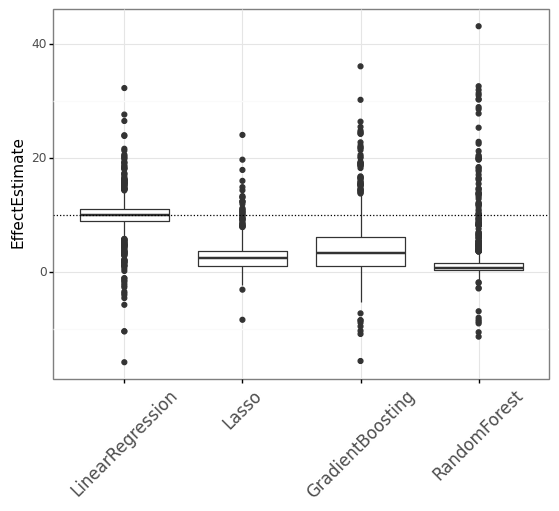

<ggplot: (8736947548657)>


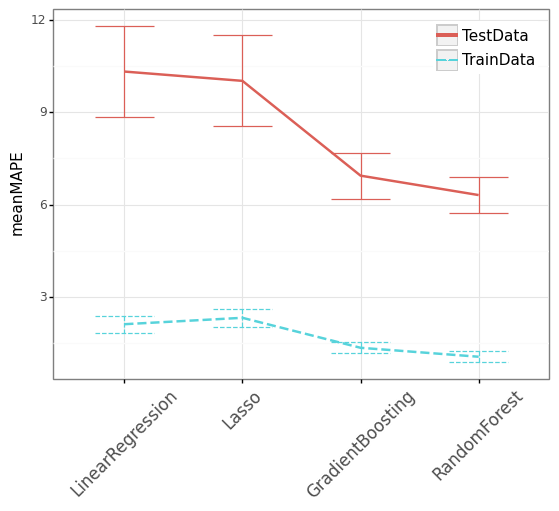

<ggplot: (8736947556958)>


In [7]:
from plotnine import ggplot, aes, geom_boxplot, geom_line, geom_hline, geom_errorbar
from plotnine import xlim, ylim, xlab, ylab, theme_bw, theme, element_text, element_blank

# Creating an ordered list of method names
ordered_method_names = ["LinearRegression", "Lasso", "GradientBoosting", "RandomForest"]
plot_df.loc[:, "method"] = pd.Categorical(plot_df["method"], categories=ordered_method_names, ordered=True)
summary_err_plot_df.loc[:, "method"] = pd.Categorical(summary_err_plot_df["method"], categories=ordered_method_names, ordered=True)

# Plotting the effect estimates
plot1 = ggplot(plot_df, aes(x="method", y="EffectEstimate")) + geom_boxplot() + geom_hline(yintercept=beta, linetype="dotted") +\
    xlab("") +theme_bw()+ theme(axis_text_x=element_text(size=12, angle=45))
plot1.save("slearner_effectestimates.pdf", height=3, width=4)

# Plotting the train/test errors (mean absolute percentage error)
plot2 = ggplot(summary_err_plot_df, aes(y="meanMAPE", x="method", group="Dataset", color="Dataset", linetype="Dataset")) + \
    geom_line(size=1)+ geom_errorbar(aes(ymin="lower_err_bar", ymax="upper_err_bar")) +\
    xlab("") + theme_bw() + theme(axis_text_x=element_text(size=12, angle=45),
                             legend_position=(0.8,0.8),
                             legend_margin=0,
                             legend_box_margin=0,
                             legend_title=element_blank(),
                             legend_text=element_text(size=11))
plot2.save("slearner_prediction_error.pdf", height=3, width=4)

print(plot1)
print(plot2)